#874351

# A1 Técnicas de Algoritmo em Ciência de Dados
Ana Carolina Erthal

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import itertools

import sklearn.metrics 
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet

import warnings
warnings.filterwarnings('ignore')

## Part 1 – Data Loading and pre-processing

First, we want to load the diamonds dataset as a pandas dataframe

In [29]:
diamonds = pd.read_csv('diamonds.csv')
print(diamonds.head())
print(f"Current size of dataframe is", diamonds.size)

   carat      cut color clarity  depth  table  price     x     y     z
0   0.23    Ideal     E     SI2   61.5   55.0    326  3.95  3.98  2.43
1   0.21  Premium     E     SI1   59.8   61.0    326  3.89  3.84  2.31
2   0.23     Good     E     VS1   56.9   65.0    327  4.05  4.07  2.31
3   0.29  Premium     I     VS2   62.4   58.0    334  4.20  4.23  2.63
4   0.31     Good     J     SI2   63.3   58.0    335  4.34  4.35  2.75
Current size of dataframe is 539400


Now we wish to get rid of all rows where any cell is empty and repeated rows:

In [30]:
diamonds[['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y', 'z']].replace('', np.nan) # makes empty values NaN
diamonds.dropna() # removes rows with NaN
diamonds.drop_duplicates() # drops any duplicate rows
print(f"Current size of dataframe is", diamonds.size)

Current size of dataframe is 539400


Now that the dataset is clean, the task is to make a fig with 2 subplots for each column in the dataframe with histograms related to it's values:

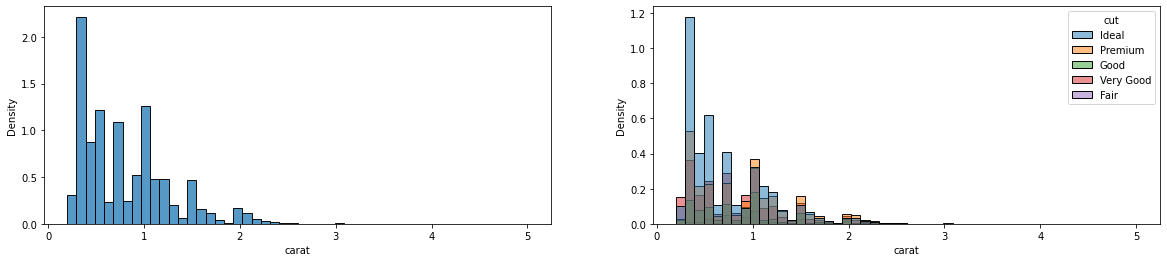

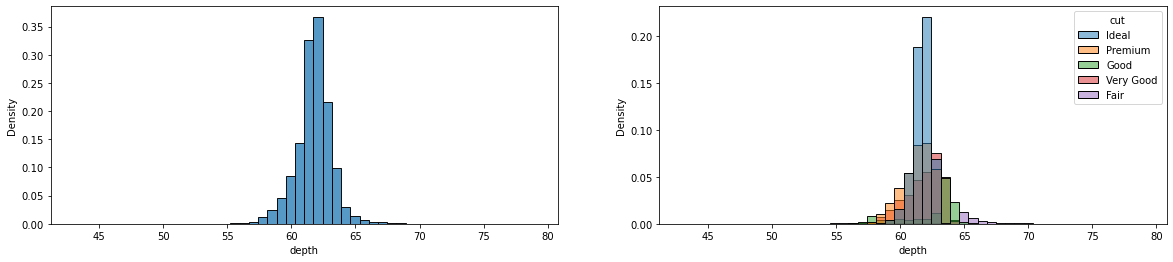

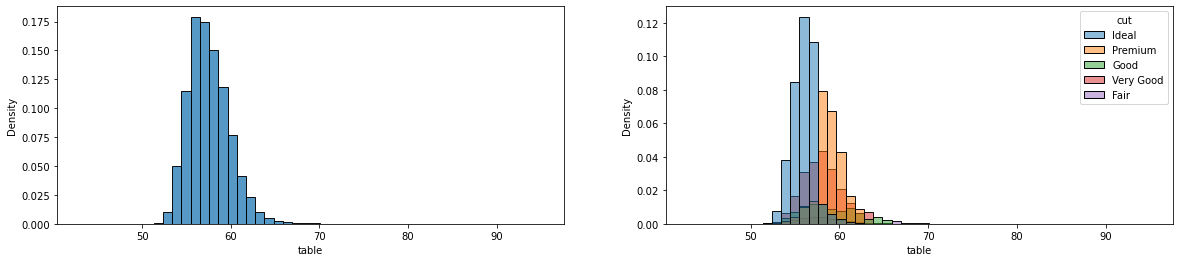

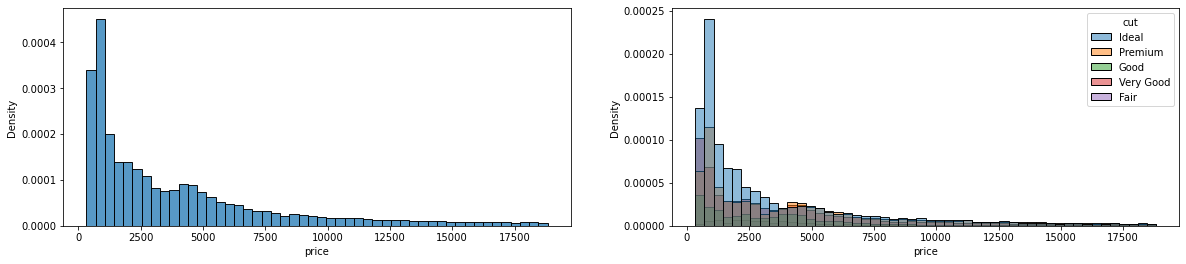

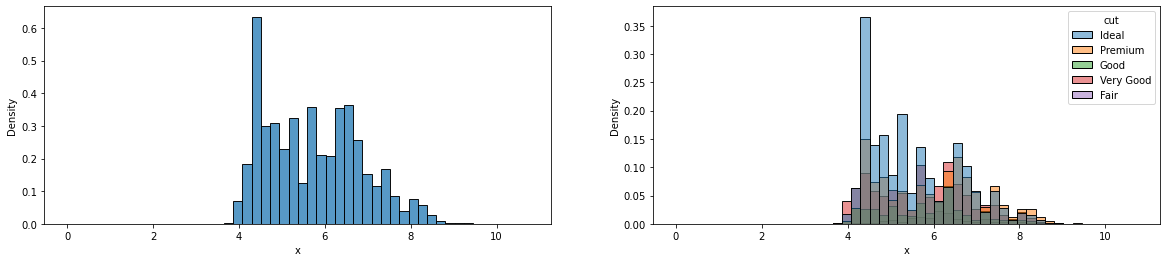

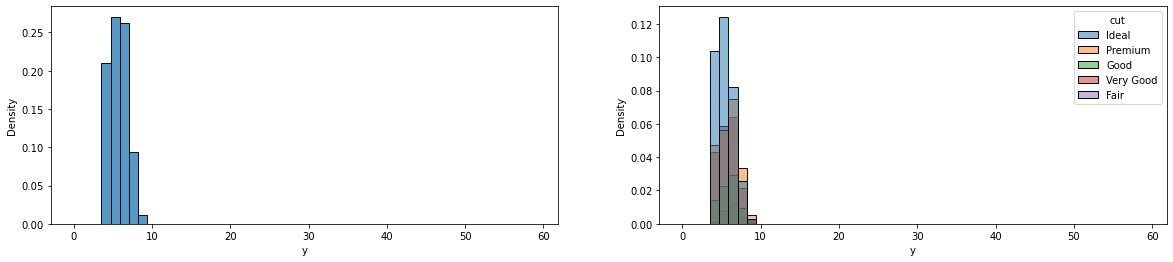

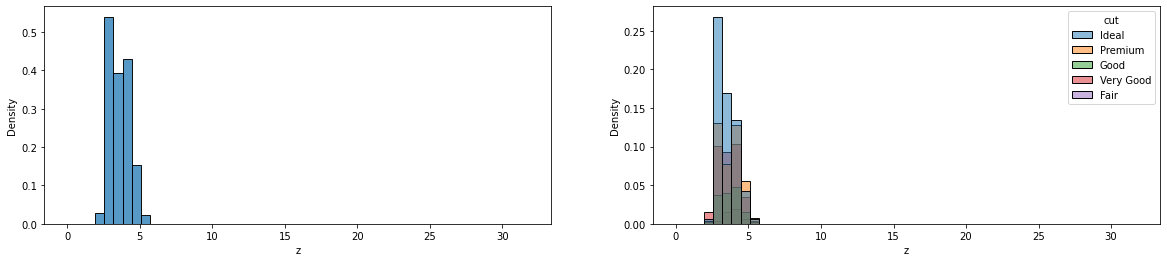

In [31]:
for col in ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']:  # loop to get fig for feature measured in numbers
    fig, axs = plt.subplots(1, 2, figsize=(20, 4))
    sns.histplot(x=diamonds[col], bins=50,  common_norm=True, stat = 'density', ax = axs[0])  # first histogram: values of the feature (all classes combined)
    sns.histplot(x=diamonds[col], hue=diamonds['cut'], bins=50,  common_norm=True, stat = 'density', ax = axs[1]) # 2nd hist: per class

plt.show()

Done! Our last task of part 1 is to create a figure (matrix of subplots) with projections for each pair of features in the dataset for L, Pearson correlation for U and the histograms we've already plotted for D.

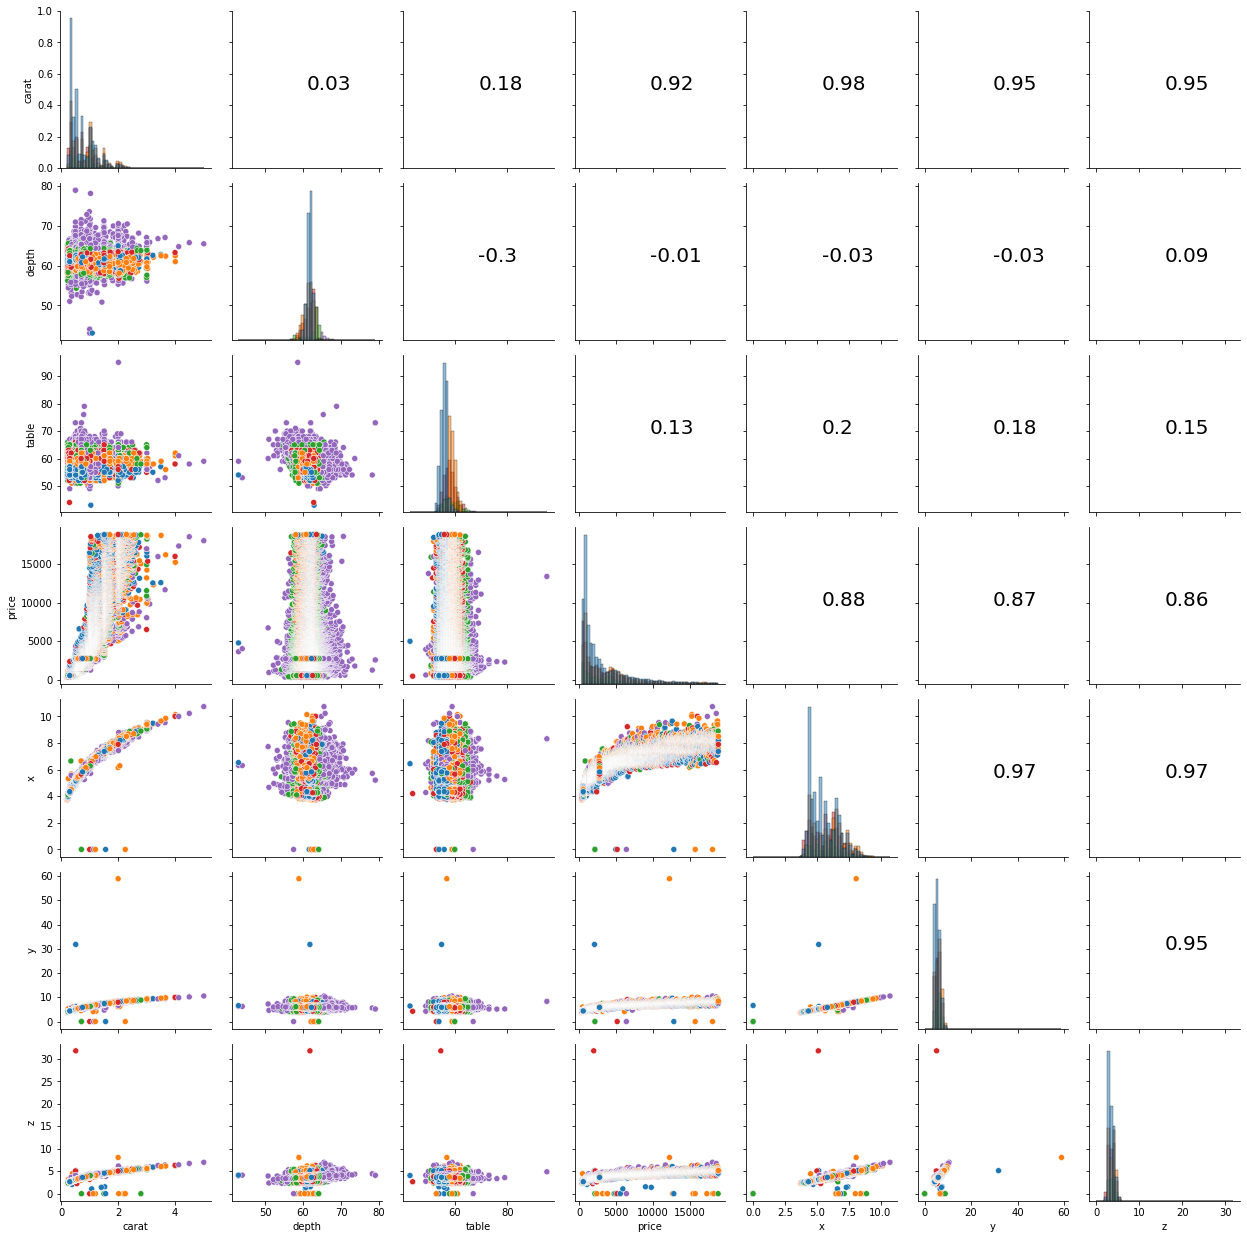

In [32]:
def pearson(x, y, **kwargs):
    pearson = np.corrcoef(x, y)[0][1]
    
    ax = plt.gca()
    ax.annotate(str(round(pearson, 2)), xy = (0.5, 0.5), size = 20, xycoords = ax.transAxes)

# chose to insert hue on the right maps so it doesn't end up plotting several correlations 
fig = sns.PairGrid(diamonds[['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut']], diag_sharey=False)

fig.map_upper(pearson, hue=None) 
fig.map_diag(sns.histplot, bins=50,  common_norm=True, stat = 'density', hue=diamonds['cut'])
fig.map_lower(sns.scatterplot, hue=diamonds['cut'])

## Part 2 – – K-nearest-neighbour classifier

Our goal now is to build a KNN classifier to run on the diamonds dataset, where we wish to predict the cut of the diamond. First, we have to split our data into training, validation and testing sets. 

In [131]:
perm = np.random.permutation(diamonds.index) #permutates diamonds to get random sets
training_end = int(0.8 * len(diamonds.index))  # 80% of data will be training 
validation_end = int(0.1 * len(diamonds.index)) + training_end # 10% of data will be validation and 10% testing
training = diamonds.loc[perm[:training_end]] 
validation = diamonds.loc[perm[training_end:validation_end]]
testing = diamonds.loc[perm[validation_end:]] 

# we'll convert them to arrays and split them into X (inputs) and y (targets)
X_train = training.drop(columns = ['cut', 'color', 'clarity'], axis=1).to_numpy() # and y, the classification feature
y_train = training['cut'].to_numpy()

X_validation = validation.drop(columns = ['cut', 'color', 'clarity'], axis=1).to_numpy()
y_validation = validation['cut'].to_numpy()

X_test = testing.drop(columns = ['cut', 'color', 'clarity'], axis=1).to_numpy()
y_test = testing['cut'].to_numpy()


In order to improve accuracy in ML algorithms, it's pretty usual to normalize the data, so we'll do it and make all our features to range from 0 to 1:

In [132]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validation_scaled = scaler.transform(X_validation)

Now that we have our sets, we wish to actually build the KNN estimator, mimicking sklearns default API for KNN with euclidian distance. 

In [136]:
class KNN(BaseEstimator):
    def __init__(self, k=5, distances = 'euclidian'): # receives the parameters as indicated
        self.k = k
        self.distances = distances

    def fit(self, X, y): # fit function
        self.X_train = X
        self.y_train = y

    def predict(self, X=None): # predict function

        predicted_labels= np.array([]) # initializes empty array for predicted labels

        if self.distances == 'euclidian': 

            for x in X:
                dist = np.linalg.norm(x - self.X_train, axis=1) # uses numpy to calculate norm for vectors (WAY FASTER THEN DOING IT FOR EACH POINT)
                indices = np.argsort(dist)[:self.k] # takes indices of k nearest neighbours
                labels = [self.y_train[element] for element in indices] # gets labels (cut) for them

                right_label = statistics.mode(labels) # the label that appears the most within k nearest neighbours
                predicted_labels = np.append(predicted_labels, right_label) # is appended to predicted_labels array
        
        elif self.distances.shape[1] == self.X_train.shape[1]:
        # if we receive matrix of pairwise similarities, do the same without calculating distance 
           for x in self.distances: 
               indices = np.argsort(x)[:self.k]
               labels = [self.y_train[element] for element in indices]

               right_label = statistics.mode(labels)
               predicted_labels = np.append(predicted_labels, right_label)
        
        else:
            raise Exception("Size of the matrix is not compatible with datapoints") # wrong matrix size, etc

        return predicted_labels

In [ ]:

classify1 = KNN(k=5, distances='euclidian')
classify1.fit(X_train_scaled, y_train)
predictions = classify1.predict(X_validation_scaled)

accuracy = np.sum(predictions == y_validation)/len(y_validation)
print(accuracy)

Now that we've ran our algorithm of KNN and got an accuracy of 0.69, let's run sklearns native KNN on the same data just to check our results! Here goes:

In [109]:
classify_check = KNeighborsClassifier(n_neighbors=5)

classify_check.fit(X_train_scaled, y_train)
predictions = classify_check.predict(X_validation_scaled)

accuracy = np.sum(predictions == y_validation)/len(y_validation)
print(accuracy)

0.6957730812013349


It's basically the same, so let's assume it was a sucess. We don't want to use sklearn, so we'll go back to our own KNN and run tests for each triad of features:

In [137]:
# redefining Xs, as I want them to be dfs again
X_train = training.drop(columns = ['cut', 'color', 'clarity'], axis=1)
X_validation = validation.drop(columns = ['cut', 'color', 'clarity'], axis=1)
X_test = testing.drop(columns = ['cut', 'color', 'clarity'], axis=1)

# redoing scaling
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=['carat', 'depth', 'table', 'price', 'x', 'y', 'z'])

X_validation_scaled = scaler.fit_transform(X_validation)
X_validation_scaled = pd.DataFrame(X_validation_scaled, columns=['carat', 'depth', 'table', 'price', 'x', 'y', 'z'])

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['carat', 'depth', 'table', 'price', 'x', 'y', 'z'])

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validation_scaled = scaler.transform(X_validation)

In [56]:
# get all combinations of 3 features 
features_list = []
for i in itertools.combinations(['carat', 'depth', 'table', 'price', 'x', 'y', 'z'], 3):
    features_list.append(list(i))

# empty dataframe to save data of our KNN for different ks:
future_df = []

# loop for each k and triad of features
for k in [2, 5, 10, 15]:
    for features in features_list:
        clf = KNN(k=k, distances='euclidian')
        clf.fit(X_train_scaled[features].to_numpy(), y_train)
        predictions = clf.predict(X=X_validation_scaled[features].to_numpy())

        accuracy = np.sum(predictions == y_validation)/len(y_validation)
        future_df.append([k,', '.join(features), accuracy])
        
df = pd.DataFrame(future_df, columns=['k', 'features', 'accuracy'])
df.head()

,k,features,accuracy
0,2,"carat, depth, table",0.036707
1,2,"carat, depth, price",0.169633
2,2,"carat, depth, x",0.152206
3,2,"carat, depth, y",0.413237
4,2,"carat, depth, z",0.362811


We now got a dataframe for all tests we ran of KNN, and wish to see highest accuracies for each k. Check below:

In [57]:
for k in [2, 5, 10, 15]:
    id = df[df.k == k].accuracy.idxmax()
    print(df.iloc[id])

k                     2
features    table, x, y
accuracy       0.417501
Name: 28, dtype: object
k                     5
features    price, x, y
accuracy       0.345384
Name: 66, dtype: object
k                    10
features    carat, y, z
accuracy       0.384501
Name: 84, dtype: object
k                    15
features    carat, y, z
accuracy        0.40267
Name: 119, dtype: object


Ok! We've found the results we wanted to. Time to plot the graphic we were asked to, showing the data above. We want to make a barplot that shows all accuracies for each k and group of features, highlighting the best one. 

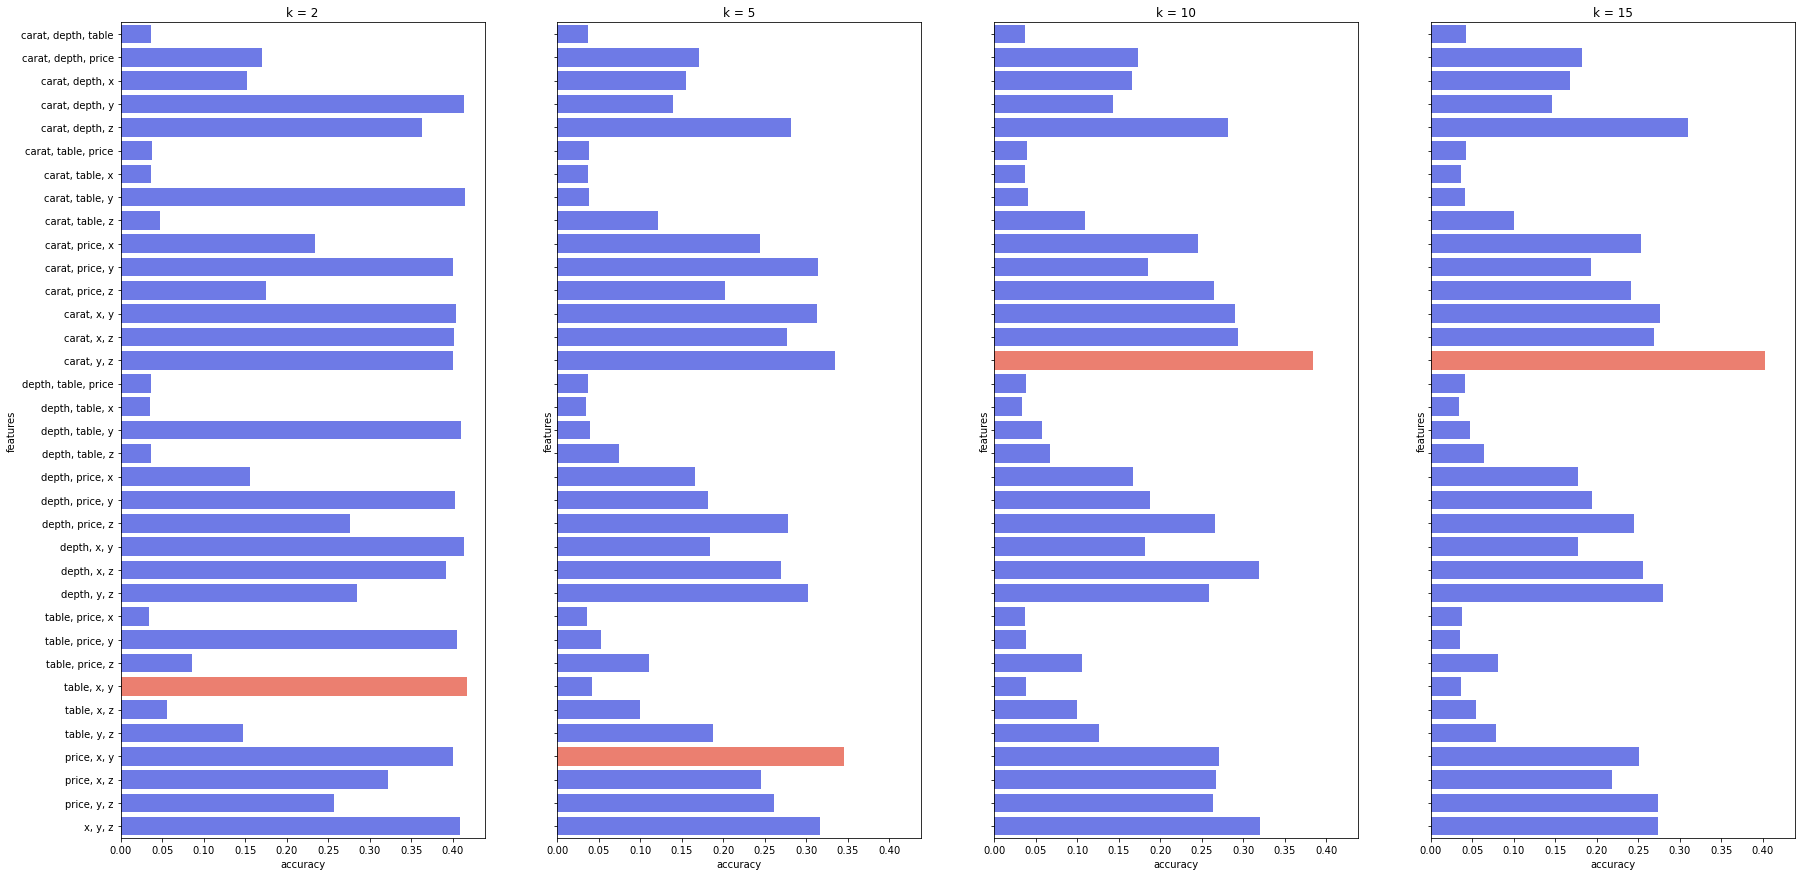

In [65]:
fig, (ax2, ax5, ax10, ax15) = plt.subplots(1, 4, figsize=(30, 15), sharex = True, sharey=True)
for number in [2, 5, 10, 15]:
    color = ['#FF705C' if (x == df[df.k == number]['accuracy'].max()) else '#5A6AFA' for x in df[df.k == number]['accuracy']]
    sns.barplot(x='accuracy', y='features', data=df[df.k == number], palette=color, ax =  locals()["ax" + str(number)]).set_title("k = "+ str(number))

They all look pretty similar, but we'd seen from the highest accuracies that it didn't change much for each k, so it's expected. And by now we've completed our tasks for the KNN algorithm. Let's move on to part 3...

# Part 3 – Linear Regression

For this part we need to build a Linear Regression with Weight Decay Regularization algorithm, accepting parameters to determine if we should do it using the closed form or SGD. We'll use the same dataset we've been doing everything on and wish to predict prices using the other numerical features. Let's get our input and target data:

In [138]:
# we'll adapt out training, testing and validation inputs and targets, as now we are missing price
X_train2 = training.drop(columns = ['price', 'cut', 'color', 'clarity'], axis=1).to_numpy() # and y, the classification feature
y_train2 = training['price'].to_numpy()

X_validation2 = validation.drop(columns = ['price', 'cut', 'color', 'clarity'], axis=1).to_numpy()
y_validation2 = validation['price'].to_numpy()

X_test2 = testing.drop(columns = ['price', 'cut', 'color', 'clarity'], axis=1).to_numpy()
y_test2 = testing['price'].to_numpy()

Now we should create the algorithm. I based my code on lab5 solutions but considering weight decay, the need of having a class, my personal considerations, etc.

In [139]:
class LinearRegression(BaseEstimator):
    def __init__(self, solver='cf', max_iter=100, learning_rate=0.0001):
        self.solver = solver
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.w = None
    
    def fit(self, X, y):
        if self.solver == 'cf':
            w0 = np.ones((X.shape[0], 1))
            wd = 0.0001 # chosen weight decay
            A = np.c_[w0, X] # concatenates A and w0
            I = np.eye(A.shape[1]) # identity sized as A
            self.w = np.linalg.inv(wd*I + A.T @ A) @ A.T @ y[:,np.newaxis] # normal equation w/ weight decay
        
        elif self.solver == 'sgd':
            n_samples, n_features = X.shape
            w0 = np.ones((n_samples, 1)) # bias
            A = np.c_[w0, X] # concatenates A and w0

            self.w = np.random.normal(scale=0.001,size=(n_features+1, 1)) # initializes weights

            # iterative part, updates w(k) using w(k-1)
            for number in range(self.max_iter):
                for sample in range(n_samples):
                    self.w += self.learning_rate * (y[sample] - A[[sample]] @ self.w) * A[[sample]].T

    def predict(self, X):
        y_predicted =  np.c_[np.ones((X.shape[0], 1)), X] @ self.w
        return y_predicted

In [72]:
classify2 = LinearRegression('sgd')
classify2.fit(X_train2, y_train2)
predictions = classify2.predict(X_validation2)

(sklearn.metrics.mean_squared_error(y_validation2, predictions))**0.5

1833.754083553216

## Part 4 - Model Comparison

For the last part we want to compare different estimators (both from sklearn library and the ones we built here):

### Classification problem

I chose to compare my own model of KNN, sklearn's KNN, Quadratic Discriminant Analysis and AdaBoost Classifier. See below:

In [154]:
X_train_validation = np.concatenate([X_train_scaled, X_validation_scaled])
y_train_validation = np.concatenate([y_train, y_validation])

In [166]:
parameters = [{'k': [2, 5, 10, 15]}]

knn = KNN()

gs = GridSearchCV(knn, parameters, scoring = 'accuracy', cv = 2)

gs.fit(X_train_validation, y_train_validation)

bs_my_knn = gs.best_params_
print(bs_my_knn)

{'k': 15}


In [77]:
# sklearn's KNN parameters
parameters = [{'n_neighbors': [2, 5, 10, 15], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 'weights': ['uniform', 'distance']}]

knn = KNeighborsClassifier()

# grid search for best parameters by accuracy
gs = GridSearchCV(knn, parameters, scoring = 'accuracy', cv=2)
gs.fit(X_train_validation, y_train_validation)

best_knn = gs.best_params_
print(best_knn)

{'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'distance'}


In [159]:
# sklearn's QuadraticDiscriminantAnalysis parameters
parameters = [{'reg_param': [0.1, 0.2, 0.3, 0.4], 'store_covariance': [False], 'tol': [0.01, 0.1, 1, 10]},
              {'reg_param': [0.1, 0.2, 0.3, 0.4], 'store_covariance': [True], 'tol': [0.01, 0.1, 1, 10]}]

qda = QuadraticDiscriminantAnalysis()

# grid search for best parameters by accuracy
gs = GridSearchCV(qda, parameters, scoring = 'accuracy', cv=2)
gs.fit(X_train_validation, y_train_validation)

best_qda = gs.best_params_
print(best_qda)

{'reg_param': 0.1, 'store_covariance': False, 'tol': 0.01}


In [82]:
# sklearn's GaussianNB parameters
parameters = [{'var_smoothing': [ 1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1, 10, 100, 1000, 10000]}]

gnb = GaussianNB()

# grid search for best parameters by accuracy
gs = GridSearchCV(gnb, parameters, scoring = 'accuracy', cv=2)
gs.fit(X_train_validation, y_train_validation)

best_gnb = gs.best_params_
print(best_gnb)

{'var_smoothing': 1e-08}


 Now that we've got all the best parameters for the algorithms, we'll run them using those and create a dataset of the accuracies:

In [189]:
knn1 = KNN(k = 15)

knn1.fit(X_train_validation, y_train_validation)
predictions = knn1.predict(X_test.to_numpy())
acc = np.sum(predictions == y_test)/len(y_test)

list1 = ['My KNearestNeighbours', acc]

In [190]:
knn2 = KNeighborsClassifier(algorithm= 'auto', n_neighbors= 15, weights= 'distance')

knn2.fit(X_train_validation, y_train_validation)
predictions = knn2.predict(X_test.to_numpy())
acc = np.sum(predictions == y_test)/len(y_test)

list2 = ['KNearestClassifier', acc]

In [191]:
qda = QuadraticDiscriminantAnalysis(reg_param= 0.1, store_covariance= False, tol= 0.01)

qda.fit(X_train_validation, y_train_validation)
predictions = qda.predict(X_test.to_numpy())
acc = np.sum(predictions == y_test)/len(y_test)

list3 = ['QuadraticDiscriminantAnalysis', acc]

In [192]:
gnb = GaussianNB(var_smoothing = 1e-08)

gnb.fit(X_train_validation, y_train_validation)
predictions = gnb.predict(X_test.to_numpy())
acc = np.sum(predictions == y_test)/len(y_test)

list4 = ['GaussianNB', acc]

In [193]:
# Let's create a df with all of those
list_all = [list1, list2, list3, list4]
classification = pd.DataFrame(list_all, columns = ['Algorithm', 'Accuracy'])
classification

,Algorithm,Accuracy
0,My KNearestNeighbours,0.265109
1,KNearestClassifier,0.265109
2,QuadraticDiscriminantAnalysis,0.265109
3,GaussianNB,0.229143


At last we wish to plot the accuracies for each of those algorithms:

<BarContainer object of 4 artists>

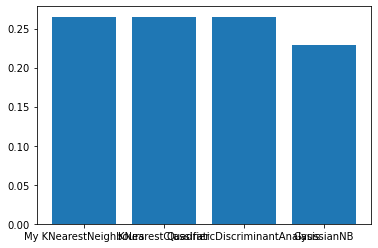

In [203]:
fig, ax = plt.subplots()
ax.bar(classification['Algorithm'], classification['Accuracy'], linewidth=0.7)

## Regression Problem

I chose to evaluate my own Linear Regression and sklearn's Bayesian Ridge, SGDRegressor and ElasticNet. 

In [83]:
X_train_validation2 = np.concatenate([X_train2, X_validation2])
y_train_validation2 = np.concatenate([y_train2, y_validation2])

In [165]:
# my own Linear Regression

parameters = [{'solver': ['cf', 'sgd'], 'max_iter': [50, 100, 150], 'learning_rate': [0.0001, 0.00001]}]
my_lr = LinearRegression()

# grid search for best parameters by accuracy
gs = GridSearchCV(my_lr, parameters, scoring = 'r2', cv = 2)
gs.fit(X_train_validation2, y_train_validation2)

best_my_lr = gs.best_params_
print(best_my_lr)

{'learning_rate': 0.0001, 'max_iter': 100, 'solver': 'sgd'}


In [90]:
# sklearn's BayesianRidge parameters
parameters = [{'n_iter': [200, 300, 400], 'tol': [0.01, 0.1, 1, 10]}]

br = BayesianRidge()

# grid search for best parameters by accuracy
gs = GridSearchCV(br, parameters, scoring = 'r2', cv=2)
gs.fit(X_train_validation2, y_train_validation2)

best_br = gs.best_params_
print(best_br)

{'n_iter': 200, 'tol': 1}


In [161]:
# sklearn's SGDRegressor parameters
parameters = [{'max_iter': [100, 200, 300], 'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'], 'penalty': ['l1', 'l2'], 'eta0': [0.01, 0.1, 1.0]}]

sgd = SGDRegressor()

# grid search for best parameters by accuracy
gs = GridSearchCV(sgd, parameters, scoring = 'r2', cv = 2)
gs.fit(X_train_validation2, y_train_validation2)

best_sgd = gs.best_params_
best_sgd

{'eta0': 0.01, 'learning_rate': 'invscaling', 'max_iter': 300, 'penalty': 'l2'}

In [164]:
# sklearn's ElasticNet parameters
parameters = [{'max_iter': [500, 1000, 1500], 'alpha': [0.001, 0.01, 0.1], 'l1_ratio': [0.3, 0.4, 0.5, 0.6]}]

en = ElasticNet()

# grid search for best parameters by accuracy
gs = GridSearchCV(en, parameters, scoring = 'r2', cv = 2)
gs.fit(X_train_validation2, y_train_validation2)

best_en = gs.best_params_
best_en

{'alpha': 0.001, 'l1_ratio': 0.3, 'max_iter': 500}